In [6]:
import time
import os
import xarray as xr
from xeofs.single import ExtendedEOF, EOF
from dask.distributed import Client
import numpy as np

variables = ['temperature', 'salinity', 'u_velocity', 'v_velocity']
analysis_method = 'EOF'

total_start = time.time()  # Start the total timer

# Initialize Dask client
start = time.time()
if 'client' not in globals():
    client = Client()
    print(f"Dask dashboard link: {client.dashboard_link}")
else:
    print("Dask client already exists. Skipping Dask client creation.")
print(f"Dask client setup time: {time.time() - start:.2f} seconds")

# Define file paths
input_path = "/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc"

# Check if input file exists
if not os.path.exists(input_path):
    raise FileNotFoundError(f"Input file not found at: {input_path}")

# Load dataset and select variable
start = time.time()
try:
    # Open and preprocess the dataset
    ds = xr.open_dataset(input_path).isel(zc=0).drop_vars('zc')
    ds = ds[variables]
    # ds = ds.isel(xc=slice(0, 50), yc=slice(0, 50), time=slice(0, 50))
    ds.attrs.clear()
    for var in ds.data_vars:
        ds[var].attrs.clear()
    data = ds.assign_coords(time=('time', range(ds.sizes['time'])))

    # Convert the dataset into a DataArray with a `variable` dimension
    combined = data.to_array(dim="variable")
    
    # Ensure the combined DataArray is ready for EOF analysis
    print("Combined DataArray dimensions:", combined.dims)
    print("Combined DataArray coordinates:", combined.coords)

except Exception as e:
    raise RuntimeError(f"Error loading, processing, or combining dataset: {e}")

# Perform analysis based on the selected method
start = time.time()
try:
    analysis_cases = {
        'ExtendedEOF': ExtendedEOF(
            n_modes=8,               # Number of modes to calculate
            tau=14,                  # Time delay between successive copies
            embedding=3,             # How many lagged dimensions to include
            n_pca_modes=500,         # How many PCA modes to retain (will run PCA before EEOF)
            center=True,             # Center the input data
            standardize=True,        # Standardize the data
            use_coslat=False,        # Do not apply cosine latitude weighting
            check_nans=True,         # Ignore NaNs in analysis
            solver='auto',           # Use the default solver
        ),
        'EOF': EOF(
            n_modes=30,               # Number of modes to calculate
            center=True,             # Center the input data
            standardize=True,        # Standardize the data
            use_coslat=False,        # Do not apply cosine latitude weighting
            check_nans=True,         # Ignore NaNs in analysis
            solver='auto',           # Use the default solver
        )
    }

    if analysis_method in analysis_cases:
        model = analysis_cases[analysis_method]
        model.fit(combined, dim=['time'])
        print(f"{analysis_method} analysis completed successfully.")
    else:
        raise ValueError(f"Unknown analysis method: {analysis_method}")
except Exception as e:
    raise RuntimeError(f"Error during {analysis_method} analysis: {e}")
print(f"{analysis_method} analysis time: {time.time() - start:.2f} seconds")

# Total time
print(f"Total execution time: {time.time() - total_start:.2f} seconds")


Dask client already exists. Skipping Dask client creation.
Dask client setup time: 0.00 seconds
Combined DataArray dimensions: ('variable', 'time', 'yc', 'xc')
Combined DataArray coordinates: Coordinates:
  * xc        (xc) float32 4kB 800.0 1.6e+03 2.4e+03 ... 7.592e+05 7.6e+05
  * yc        (yc) float32 2kB 800.0 1.6e+03 2.4e+03 ... 4.432e+05 4.44e+05
  * time      (time) int64 3kB 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
  * variable  (variable) object 32B 'temperature' 'salinity' ... 'v_velocity'


/cluster/home/haroldh/.conda/envs/eof/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


EOF analysis completed successfully.
EOF analysis time: 45.63 seconds
Total execution time: 162.11 seconds


In [9]:
model.explained_variance_ratio().compute()

<xarray.DataArray 'explained_variance_ratio' (mode: 30)> Size: 240B
array([0.30390074, 0.1092158 , 0.04609273, 0.0347343 , 0.03304871,
       0.02511838, 0.02224332, 0.01984197, 0.01594518, 0.01370948,
       0.01309783, 0.01263333, 0.01189745, 0.01132315, 0.01015242,
       0.00924321, 0.00803427, 0.00791032, 0.00753271, 0.00696842,
       0.00648197, 0.00613824, 0.00573343, 0.00527127, 0.00507395,
       0.00499719, 0.00484969, 0.00455332, 0.00438576, 0.00421532])
Coordinates:
  * mode     (mode) int64 240B 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-01-16 14:30:48
    n_modes:        30
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

In [7]:
model.save("/cluster/home/haroldh/spGDMM/1_data/4_interim/EOFs/EOF_30tsuv.nc", overwrite=True, engine='zarr')

In [1]:
import xeofs

model = xeofs.single.ExtendedEOF.load("/cluster/home/haroldh/spGDMM/1_data/4_interim/EOFs/EEOF_tsuve_50pca.nc")

KeyboardInterrupt: 

In [6]:
import xeofs

eof = xeofs.single.EOF.load("/cluster/home/haroldh/spGDMM/1_data/4_interim/EOFs/EOF_tsuv.nc")

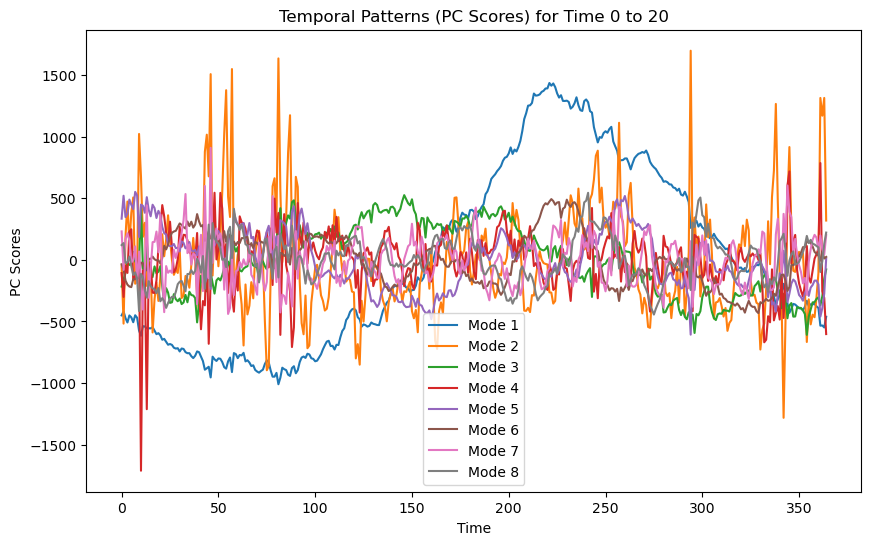

In [15]:
import matplotlib.pyplot as plt

scores = eof.scores()

# Plot scores for the first few modes, limited to time 0 to 20
n_modes = 8
plt.figure(figsize=(10, 6))
for mode in range(n_modes):
    plt.plot(scores['time'], scores.sel(mode=mode + 1), label=f"Mode {mode + 1}")

plt.xlabel("Time")
plt.ylabel("PC Scores")
plt.title("Temporal Patterns (PC Scores) for Time 0 to 20")
plt.legend()
plt.show()

/cluster/home/haroldh/.conda/envs/eof/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 11.75 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


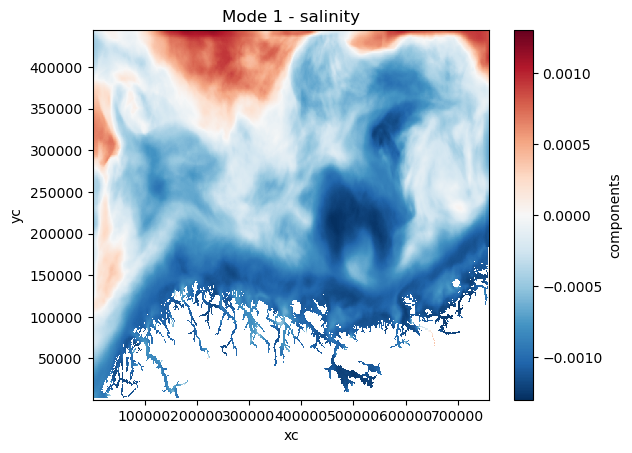

/cluster/home/haroldh/.conda/envs/eof/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 10.14 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


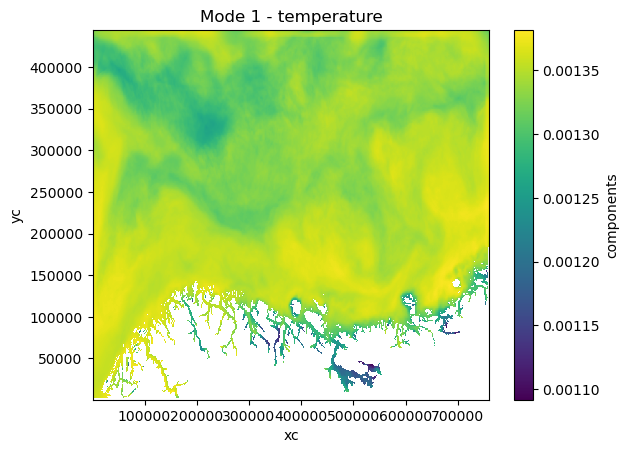

/cluster/home/haroldh/.conda/envs/eof/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 10.97 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


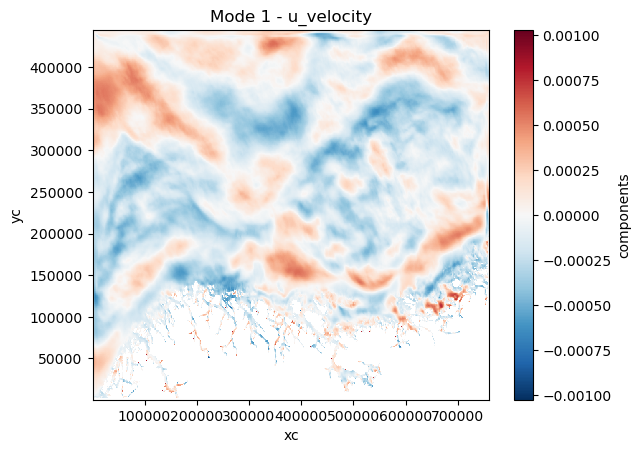

/cluster/home/haroldh/.conda/envs/eof/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 10.03 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


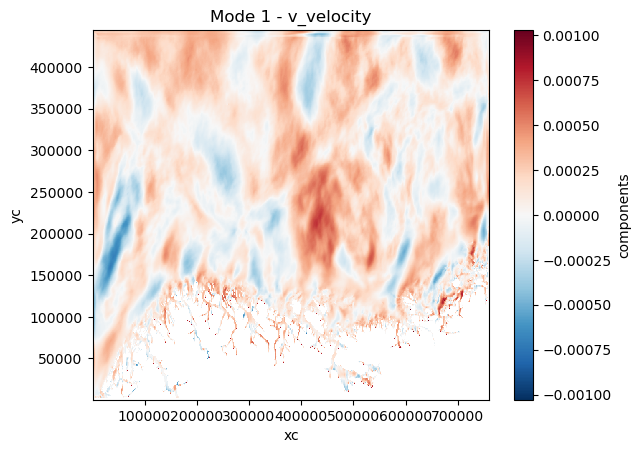

/cluster/home/haroldh/.conda/envs/eof/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 35.53 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


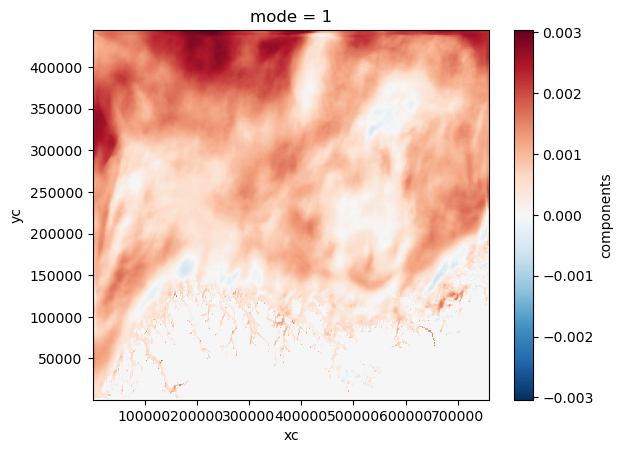

In [13]:
import matplotlib.pyplot as plt

components = eof.components()
for var in eof.components()['variable'].values:
    plt.figure()
    components.sel(mode=1, variable=var).plot()
    plt.title(f"Mode 1 - {var}")
    plt.show()

plt.figure()
components.sum(dim='variable').sel(mode=1).plot()

Explained Variance for each mode:
[515785.46738251 185362.9078923   78229.36012612  58951.64716112
  56090.83678241  42631.32123098  37751.73289678  33675.87202508]


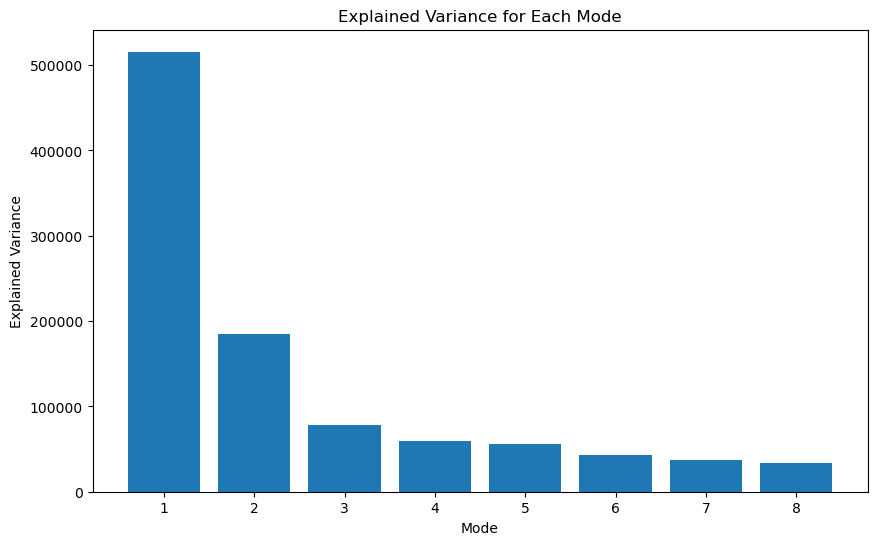

In [38]:
# Get explained variance for each mode
explained_variance = eof.explained_variance().values

# Print explained variance
print("Explained Variance for each mode:")
print(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 6))
sorted_explained_variance
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Mode")
plt.ylabel("Explained Variance")
plt.title("Explained Variance for Each Mode")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Access components: (feature, embedding, mode)
components = model.components()

# Iterate over modes and embeddings
n_modes = 2
for mode in range(n_modes):
    for var in model.components()['variable']:
        fig, axes = plt.subplots(1, components.sizes['embedding'], figsize=(15, 5))
        fig.suptitle(f"Mode {mode + 1} - Spatial Patterns")

        for i, emb in enumerate(components['embedding']):
            ax = axes[i]
            component = components.sel(mode=mode + 1, embedding=emb, variable=var)
            component.plot(ax=ax)
            ax.set_title(f"Embedding {emb.values}")

        plt.tight_layout()
        plt.show()


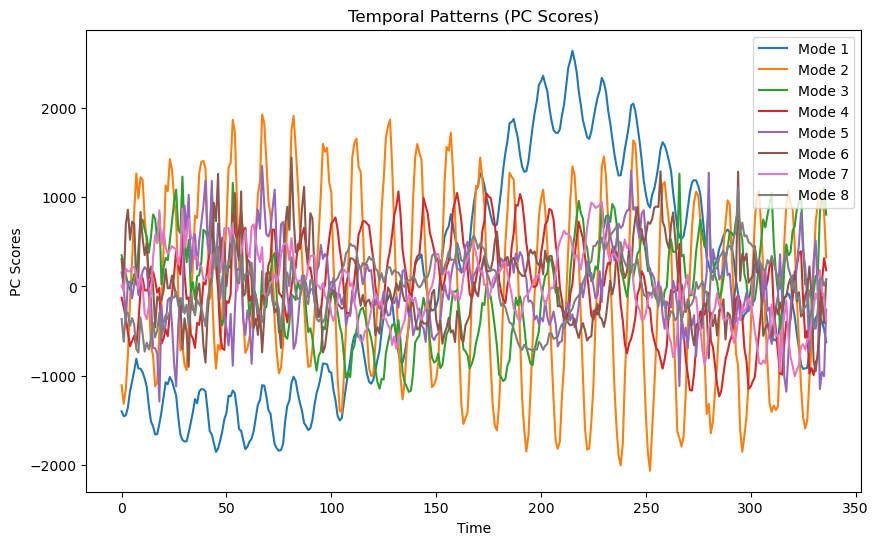

In [11]:
# Access scores: (time, mode)
scores = model.scores()

# Plot scores for the first few modes
n_modes = 8
plt.figure(figsize=(10, 6))
for mode in range(n_modes):
    plt.plot(scores['time'], scores.sel(mode=mode + 1), label=f"Mode {mode + 1}")

plt.xlabel("Time")
plt.ylabel("PC Scores")
plt.title("Temporal Patterns (PC Scores)")
plt.legend()
plt.show()
